In [1]:
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet import MobileNet
from efficientnet.keras import EfficientNetB0
from efficientnet.keras import EfficientNetB1
from efficientnet.keras import EfficientNetB2
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Model
import cv2

class VasyaPointDetector():
    def __init__(self, model_path, model_type = 'mobilenet_v2'):
        if model_type == 'efficientnet_b0':
            model = EfficientNetB0(input_shape=(112, 112, 3), classes=68*2, weights=None)
        elif model_type == 'efficientnet_b1':
            model = EfficientNetB1(input_shape=(112, 112, 3), classes=68*2, weights=None)
        elif model_type == 'efficientnet_b2':
            model = EfficientNetB2(input_shape=(112, 112, 3), classes=68*2, weights=None)
        elif model_type == 'mobilenet':
            model = MobileNet(input_shape=(112, 112, 3), classes=68*2, weights=None)
        else:
            model = MobileNetV2(input_shape=(112, 112, 3), classes=68*2, weights=None)

        out = model.layers[-2].output
        out = Dense(68*2, activation ='linear')(out)
        model = Model(inputs = model.input, outputs = out)
        model.compile(optimizer=Adam(), loss = 'mse')
        
        with open(model_path, 'rb') as f:
            model.load_weights(f)
            
        self.model = model
        
    def __cut__(self, image, cords, im_size=112):
        face = cords
        target_size = im_size

        w = face[2] - face[0] + 1
        h = face[3] - face[1] + 1
        
        s = max(w, h)
        if (h < s):
            dh = s - h
            dh_up = face[1]
            dh_down = image.shape[0] - face[3] - 1
            if dh_up + dh_down < dh:
                face[1] = 0
                face[3] = image.shape[0] - 1
            else:
                dh_up_inc = dh // 2 + dh % 2
                dh_down_inc = dh // 2
                if dh_up < dh_up_inc:
                    dh_down_inc += dh_up_inc - dh_up
                    dh_up_inc = dh_up
                elif dh_down < dh_down_inc:
                    dh_up_inc += dh_down_inc - dh_down
                    dh_down_inc = dh_down
                face[1] -= dh_up_inc
                face[3] += dh_down_inc
                
        elif (w < s):
            dw = s - w
            dw_up = face[0]
            dw_down = image.shape[1] - face[2] - 1
            if dw_up + dw_down < dw:
                face[0] = 0
                face[2] = image.shape[1] - 1
            else:
                dw_up_inc = dw // 2 + dw % 2
                dw_down_inc = dw // 2
                if dw_up < dw_up_inc:
                    dw_down_inc += dw_up_inc - dw_up
                    dw_up_inc = dw_up
                elif dw_down < dw_down_inc:
                    dw_up_inc += dw_down_inc - dw_down
                    dw_down_inc = dw_down
                face[0] -= dw_up_inc
                face[2] += dw_down_inc
    
        if face[2] == image.shape[1]:
            face[2] -= 1
        if face[3] == image.shape[0]:
            face[3] -= 1
        if not (face[0] >= 0 and face[1] >= 0 and face[2] + 1 <= image.shape[1] and face[3] + 1 <= image.shape[0]):
            print(face, image.shape)
        assert face[0] >= 0 and face[1] >= 0 and face[2] <= image.shape[1] and face[3] <= image.shape[0]

        cut_face = image[face[1]:face[3] + 1, face[0]:face[2] + 1]
        distortion = (face[3] - face[1] + 1) / (face[2] - face[0] + 1)
    
        return cv2.resize(cut_face, (target_size, target_size)), face
    
    def get_model(self):
        return self.model
    
    def detect_points(self, boxes, image):
        result = np.zeros((len(boxes), 68, 2))
        for i in range(result.shape[0]):
            cuted_image, cut_meta = self.__cut__(image, boxes[i])
            predict = self.model.predict(cuted_image.reshape(1, 112, 112, 3)).reshape(68, 2)
            result[i, :, 0] = predict[:, 0] / (112.0 / (cut_meta[2] - cut_meta[0])) + cut_meta[0]
            result[i, :, 1] = predict[:, 1] / (112.0 / (cut_meta[3] - cut_meta[1])) + cut_meta[1]
        
        return result

Using TensorFlow backend.


In [2]:
pd = VasyaPointDetector('MobileNetV2')

In [3]:
from skimage import io
import cv2
import matplotlib.pyplot as plt

In [71]:
img = io.imread("11.jpg")

In [72]:
img.shape

(428, 362, 3)

In [74]:
img = img[:362]

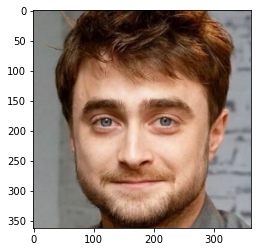

In [75]:
plt.imshow(img)

In [76]:
detected = pd.detect_points([[0, 0, 361, 361]], img)

In [77]:
detected.shape

(1, 68, 2)

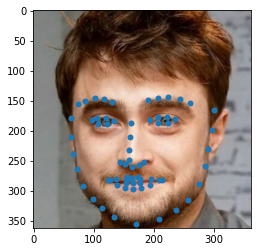

In [78]:
plt.imshow(img)
plt.scatter(detected[0, :, 0], detected[0, :, 1], linewidth = 0.001)
plt.savefig('putin1.jpg', dpi = 1200)